In [1]:
from functools import partial

from jax.config import config
config.update("jax_enable_x64", True)
config.update('jax_platform_name', 'cpu')
import jax.numpy as jnp
from jax import jit, lax, random, vmap

from caustics.ehrlich_aberth_primitive import poly_roots
from caustics.point_source_magnification import _poly_coeffs_binary
from caustics import critical_and_caustic_curves

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
@jit
def single_quadratic(a0, b0, c0):
    ''' Analytical solver for a single quadratic equation
    (2nd order polynomial).
    Parameters
    ----------
    a0, b0, c0: array_like
        Input data are coefficients of the Quadratic polynomial::
            a0*x^2 + b0*x + c0 = 0
    Returns
    -------
    r1, r2: tuple
        Output data is a tuple of two roots of a given polynomial.
    '''
    ''' Reduce the quadratic equation to to form:
        x^2 + ax + b = 0'''
    a, b = b0 / a0, c0 / a0

    # Some repeating variables
    a0 = -0.5*a
    delta = a0*a0 - b
    sqrt_delta = jnp.sqrt(delta+0j)

    # Roots
    r1 = a0 - sqrt_delta
    r2 = a0 + sqrt_delta

    return r1, r2

@jit
def single_cubic_one(a, b, c, d):
    third = 1./3.
    d0 = b*b-3*a*c
    d1 = 2*b*b*b-9*a*b*c+27*a*a*d
    d2 = jnp.sqrt(d1*d1-4*d0*d0*d0+0j)
    
    d3 = jnp.where(d2==d1, d1 + d2, d1 - d2)
    
    C = (d3/2)**third
    d4 = jnp.where((C == 0)*(d0 == 0), 0, d0/C)

    return -1/3/a*(b+C+d4)


@jit
def single_quartic(a0, b0, c0, d0, e0):
    ''' Analytical closed-form solver for a single quartic equation
    (4th order polynomial). Calls `single_cubic_one` and
    `single quadratic`.
    Parameters
    ----------
    a0, b0, c0, d0, e0: array_like
        Input data are coefficients of the Quartic polynomial::
        a0*x^4 + b0*x^3 + c0*x^2 + d0*x + e0 = 0
    Returns
    -------
    r1, r2, r3, r4: tuple
        Output data is a tuple of four roots of given polynomial.
    '''

    ''' Reduce the quartic equation to to form:
        x^4 + a*x^3 + b*x^2 + c*x + d = 0'''
    a, b, c, d = b0/a0, c0/a0, d0/a0, e0/a0

    # Some repeating variables
    a0 = 0.25*a
    a02 = a0*a0

    # Coefficients of subsidiary cubic equation 
    p = 3*a02 - 0.5*b
    q = a*a02 - b*a0 + 0.5*c
    r = 3*a02*a02 - b*a02 + c*a0 - d

    # One root of the cubic equation
    z0 = single_cubic_one(1, p, r, p*r - 0.5*q*q)

    # Additional variables
    s = jnp.sqrt(2*p + 2*z0 + 0j)
    t = jnp.where(s==0, z0*z0 + r, -q/s)

    # Compute roots by quadratic equations
    r0, r1 = single_quadratic(1, s, z0 + t)
    r2, r3 = single_quadratic(1, -s, z0 - t)

    return jnp.array([r0 - a0, r1 - a0, r2 - a0, r3 - a0])

@jit
def newton_update(z, coeffs):
    return z - jnp.polyval(coeffs, z) / jnp.polyval(jnp.polyder(coeffs), z)

@partial(jit, static_argnames=("niter"))
def find_isolated_root(w, a, e1, niter=50):
    coeffs5 = _poly_coeffs_binary(w, a, e1)
    
    # Coordinate origin to primary
    w = (w + a) / (1 - e1)**0.5
    
    # Initial guess for the isolated root 
    w_abs_sq = w.real**2 + w.imag**2
    z1 = 0.5 * w * (1.0 + jnp.sqrt(1 + 4 / w_abs_sq))
    z2 = 0.5 * w * (1.0 - jnp.sqrt(1 + 4 / w_abs_sq))
    z_init = jnp.where(w.real < 0., z1, z2)
    z_init = z_init * (1 - e1)**0.5 - a

    # Find isolated root using Newton's method
    def body_fn(z, _):
        z = newton_update(z, coeffs5)
        return z, 0

    z_final, _ = lax.scan(body_fn, z_init, None, length=niter)

    return z_final

@jit
def roots_of_fourth_order_poly(a, e1, w, z0):
    """Solve for the roots of the 4th order complex polynomial."""
    # evaluate reduced quartic polynomial in closed-form
    
    q = e1 / (1 - e1) 
    
    s = 2 * a / (1 - e1)**0.5
    w = (w + a) / (1 - e1)**0.5
    z0 = (z0 + a) / (1 - e1)**0.5

    wbar = jnp.conjugate(w)

    coeff0 = -((s**3-2*z0-4*s**2*z0+s*(2+3*z0**2))*w)+\
            2*q**2*z0*(-s+w)+\
            q*(4*z0*w+s**2*(1-3*z0**2+2*z0*w)+\
            s*(-2*z0+4*z0**3-2*w-3*z0**2*w))+(-2*(1+\
            q)*z0**2*(2*z0-3*w)+s**3*z0*(3*z0-2*w)+\
            s*z0*(6*z0+5*z0**3-4*(2+q)*w-4*z0**2*w)+\
            2*s**2*((-1+q)*z0-4*z0**3+w+\
            3*z0**2*w))*wbar-(s-z0)*z0*(3*s*z0-\
            5*z0**2-2*s*w+4*z0*w)*wbar**2
                
    coeff1 = (1+2*s**2-3*s*z0)*w+q**2*(-s+w)+\
            q*(2*w+s**2*(-3*z0+w)+\
            s*(-1+6*z0**2-3*z0*w))+(-6*(1+q)*z0*(z0-w)+\
            s**3*(3*z0-w)+s**2*(-1+q-12*z0**2+6*z0*w)+\
            2*s*(3*z0+5*z0**3-(2+q)*w-\
            3*z0**2*w))*wbar+(6*s*z0*(2*z0-w)\
            +s**2*(-3*z0+w)+\
            2*z0**2*(-5*z0+3*w))*wbar**2
    
    coeff2 = -s*(w+q*(s-4*z0+w))+(s**3-\
            2*(1+q)*(2*z0-w)+s**2*(-8*z0+2*w)+\
            2*s*(1+5*z0**2-2*z0*w))*wbar-(s**2-\
            8*s*z0+10*z0**2+2*s*w-\
            4*z0*w)*wbar**2
                
    coeff3 = q*s-(1+q+2*s**2-5*s*z0+\
            s*w)*wbar+(2*s-\
            5*z0+w)*wbar**2

    coeff4 = s*wbar-wbar**2
    
    coeffs = jnp.array([coeff0, coeff1, coeff2, coeff3, coeff4])
    
    z = single_quartic(*list(coeffs[::-1])) + z0

    return z * (1 - e1)**0.5 - a

@partial(jit, static_argnames=("niter"))
def roots_semi_analytic(w, a, e1, niter=100):
    z_isolated = find_isolated_root(w, a, e1, niter=niter)
    z_other = roots_of_fourth_order_poly(a, e1, w, z_isolated)
    return jnp.concatenate([jnp.atleast_1d(z_isolated), z_other])


In [3]:
a = 0.45
e1 = 0.05

key = random.PRNGKey(42)
key, subkey1, subkey2 = random.split(key, num=3)

# Generate random test points near the caustics
rho = 1e-03
critical_curves, caustic_curves = critical_and_caustic_curves(
    nlenses=2, npts=50, a=a, e1=e1, 
)

w_test = (
    caustic_curves
    + random.uniform(subkey1, caustic_curves.shape, minval=-0.1 * rho, maxval=0.1 * rho)
    + 1j
    * random.uniform(subkey2, caustic_curves.shape, minval=-0.1 * rho, maxval=0.1 * rho)
)
w_test.shape

(200,)

In [4]:
coeffs_stacked = vmap(lambda w: _poly_coeffs_binary(w, a, e1))(w_test)
coeffs_stacked.shape

(200, 6)

In [5]:
# Aberth-Ehrlich
roots1 = poly_roots(coeffs_stacked).sort(axis=1)
roots1.shape

(200, 5)

In [6]:
# Semi-Analytic
roots2 = vmap(lambda w: roots_semi_analytic(w, a, e1, niter=15))(w_test)
roots2 = roots2.sort(axis=1)
roots2.shape

(200, 5)

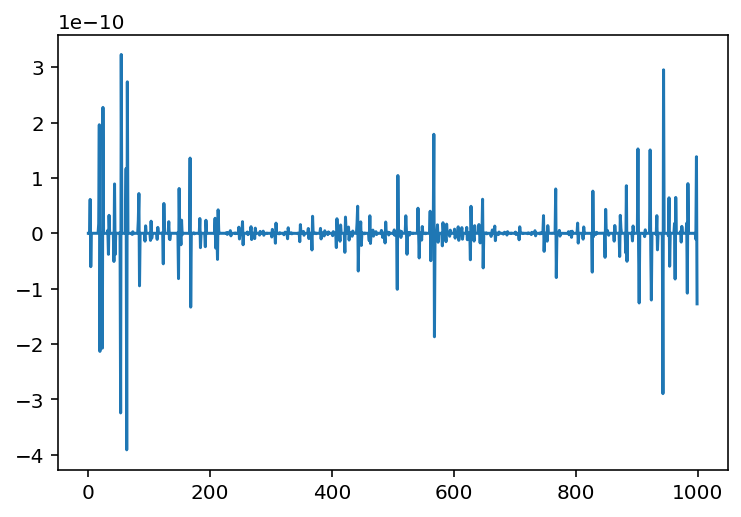

In [7]:
import matplotlib.pyplot as plt
plt.plot((roots1 - roots2).reshape(-1))

In [8]:
%%timeit
roots1 = poly_roots(coeffs_stacked).block_until_ready()

704 µs ± 8.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
%%timeit
roots2 = vmap(lambda w: roots_semi_analytic(w, a, e1, niter=50))(w_test)
roots2.block_until_ready()


974 µs ± 75.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
0.6/500/500

2.4e-06

In [12]:
800/200

4.0